# Replication Notebook for Figs. 1, 2 and 3

This notebook contains the code and figure for replication of Figs. 1, 2, 3 and 7 in XX. 

Figs. 1, 2, 3 and 7 were generated through R. Please follow the installation instructions provided in README.

## Imports

In [3]:
library(tidyverse)
library(magrittr)

## Data loading

Evaluate the following cell to load the data. By default, aggregated data files should have been downloaded in the sub-folder called `data`, relative to the path of the notebook itself. If you downloaded the data to a different location, change the value of the `data_path` variable below.

In [4]:
data_path = 'data/'

pulse <- read_csv(paste(data_path, "Fig_1_2_3_7/pulse_newsguard_merged.csv", sep=""))
ng <- read_csv(paste(data_path, "Fig_1_2_3_7/newsguard_anonymized.csv", sep=""))

Parsed with column specification:
cols(
  rowid = col_double(),
  Score = col_double(),
  log_n = col_double(),
  visitor_avg = col_double(),
  visitor_var = col_double(),
  pageview_avg = col_double(),
  pageview_var = col_double(),
  is_conservative = col_double()
)
Parsed with column specification:
cols(
  id = col_double(),
  Score = col_double()
)


## Functions

In [5]:
standardize <- function(vec) {
  avg <- mean(vec, na.rm = T)
  std_dev <- sd(vec, na.rm = T)
  vec_new <- (vec - avg) / std_dev
  return(vec_new)
}

## Calculate Quantities

### Correlations quality vs popularity

In [13]:
cor.test(pulse$Score, pulse$log_n, use = "complete.obs")
cor.test(pulse[pulse$is_conservative == 1,]$Score, 
         pulse[pulse$is_conservative == 1,]$log_n, use = "complete.obs")
cor.test(pulse[pulse$is_conservative == 0,]$Score, 
         pulse[pulse$is_conservative == 0,]$log_n, use = "complete.obs")


	Pearson's product-moment correlation

data:  pulse$Score and pulse$log_n
t = 1.551, df = 1022, p-value = 0.1212
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01284175  0.10939558
sample estimates:
       cor 
0.04845836 



	Pearson's product-moment correlation

data:  pulse[pulse$is_conservative == 1, ]$Score and pulse[pulse$is_conservative == 1, ]$log_n
t = -0.95403, df = 235, p-value = 0.3411
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18805537  0.06583785
sample estimates:
        cor 
-0.06211356 



	Pearson's product-moment correlation

data:  pulse[pulse$is_conservative == 0, ]$Score and pulse[pulse$is_conservative == 0, ]$log_n
t = 2.3698, df = 781, p-value = 0.01804
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.01451659 0.15364706
sample estimates:
       cor 
0.08449364 


### Partial correlations quality vs variance controlling for partisanship 

#### User level

In [14]:
pulse_with_ng <- filter(pulse, !is.na(Score))
reg1 <- lm(Score ~ visitor_avg, data = pulse_with_ng)
res1 <- reg1$residuals
reg2 <- lm(visitor_var ~ visitor_avg, data = pulse_with_ng)
res2 <- reg2$residuals
cor.test(res1, res2, use = "complete.obs")


	Pearson's product-moment correlation

data:  res1 and res2
t = 13.011, df = 1022, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3231715 0.4283401
sample estimates:
      cor 
0.3769701 


#### Pageview level

In [15]:
reg3 <- lm(Score ~ pageview_avg, data = pulse_with_ng)
res3 <- reg3$residuals
reg4 <- lm(pageview_var ~ pageview_avg, data = pulse_with_ng)
res4 <- reg4$residuals
cor.test(res3, res4, use = "complete.obs")


	Pearson's product-moment correlation

data:  res3 and res4
t = 7.2285, df = 1022, p-value = 9.551e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1614629 0.2780486
sample estimates:
      cor 
0.2205433 


### Regress NewsGuard scores on partisanship variance 

#### User level

In [17]:
pulse_partisans_only <- 
  pulse %>%
  filter(!is.na(is_conservative)) 
user_mod <- lm(standardize(Score) ~ standardize(visitor_var), 
               data = pulse_partisans_only)
user_r <- lm(standardize(Score) ~ standardize(visitor_var), 
             data = filter(pulse_partisans_only, is_conservative == 1))
user_d <- lm(standardize(Score) ~ standardize(visitor_var), 
             data = filter(pulse_partisans_only, is_conservative == 0))

#### Pageview level

In [18]:
pview_mod <- lm(standardize(Score) ~ standardize(pageview_var), 
                data = pulse_partisans_only)
pview_r <- lm(standardize(Score) ~ standardize(pageview_var), 
             data = filter(pulse_partisans_only, is_conservative == 1))
pview_d <- lm(standardize(Score) ~ standardize(pageview_var), 
             data = filter(pulse_partisans_only, is_conservative == 0))

## Figure 1

__caption__: _Relationship between audience size and news quality by domain. The Pearson correlation is r=0.05, two-sided p=0.11. Reliability scores provided by NewsGuard_

Warning message:
“Removed 10769 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10769 rows containing missing values (geom_point).”

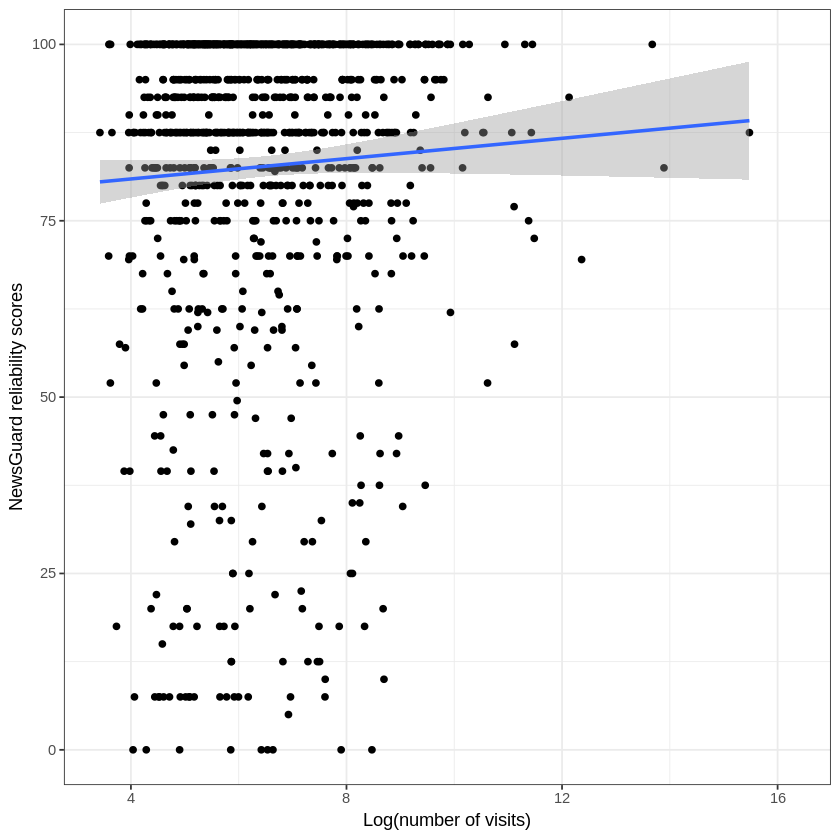

In [19]:
pulse %>% 
  ggplot(aes(x = log_n, y = Score)) + 
  geom_point() + 
  geom_smooth(method = "lm", formula = y~x) + 
  theme_bw() + 
  xlab("Log(number of visits)") + ylab("NewsGuard reliability scores")

## Figure 2 (Left)

__caption__: _Average audience partisanship versus variance (User level). Domains for which we have NewsGuard reliability scores are shaded in blue (where darker shades equal lower scores). Domains with no available score are plotted in gray._

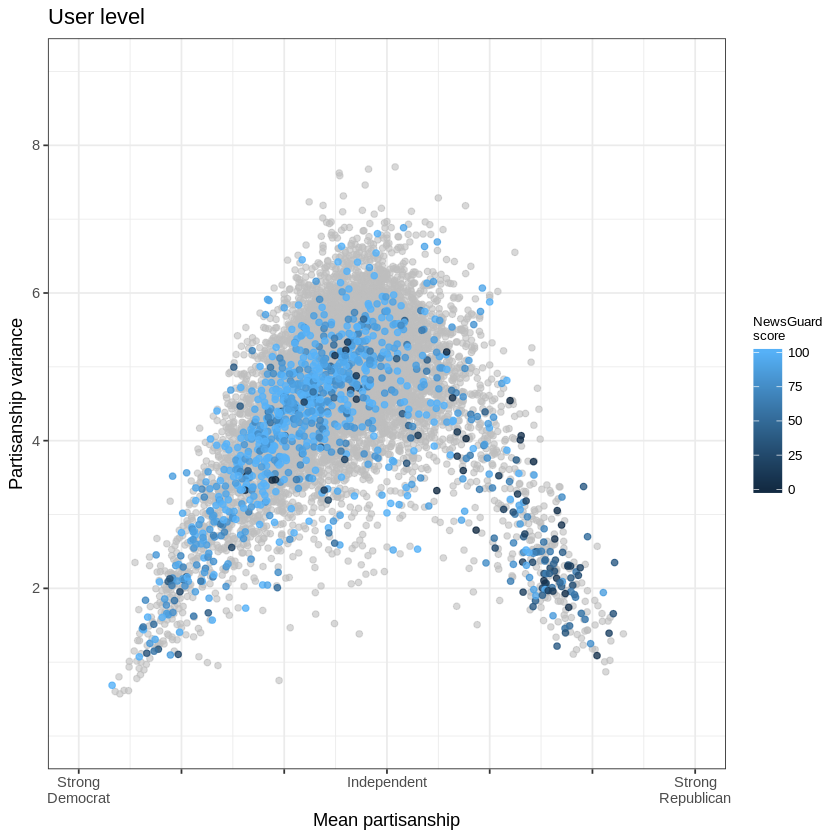

In [23]:
pulse %>% 
ggplot(aes(x = visitor_avg, y = visitor_var)) + 
geom_point(data = filter(pulse, is.na(Score)),
             aes(x = visitor_avg, y = visitor_var), 
             color = "grey", alpha = 0.6) +
geom_point(data = filter(pulse, !is.na(Score)),
             aes(x = visitor_avg, y = visitor_var, 
                 color = Score), alpha = 0.8) +
scale_color_gradient() +
theme_bw() + 
theme(legend.title = element_text(size = 8),
      legend.text = element_text(size = 8)) +
scale_x_continuous(
    "Mean partisanship",
    limits = c(1, 7),
    breaks = seq(1,7, by = 1),
    labels = c("Strong\nDemocrat", "", "", "Independent",
               "", "", "Strong\nRepublican")
) + 
scale_y_continuous(
    "Partisanship variance",
    limits = c(0, 9),
    breaks = seq(2, 8, by = 2)
) +
ggtitle("User level") +
labs(color = "NewsGuard\nscore")

## Figure 2 (Right)

__caption__: _Average audience partisanship versus variance (Pageview level). Domains for which we have NewsGuard reliability scores are shaded in blue (where darker shades equal lower scores). Domains with no available score are plotted in gray._

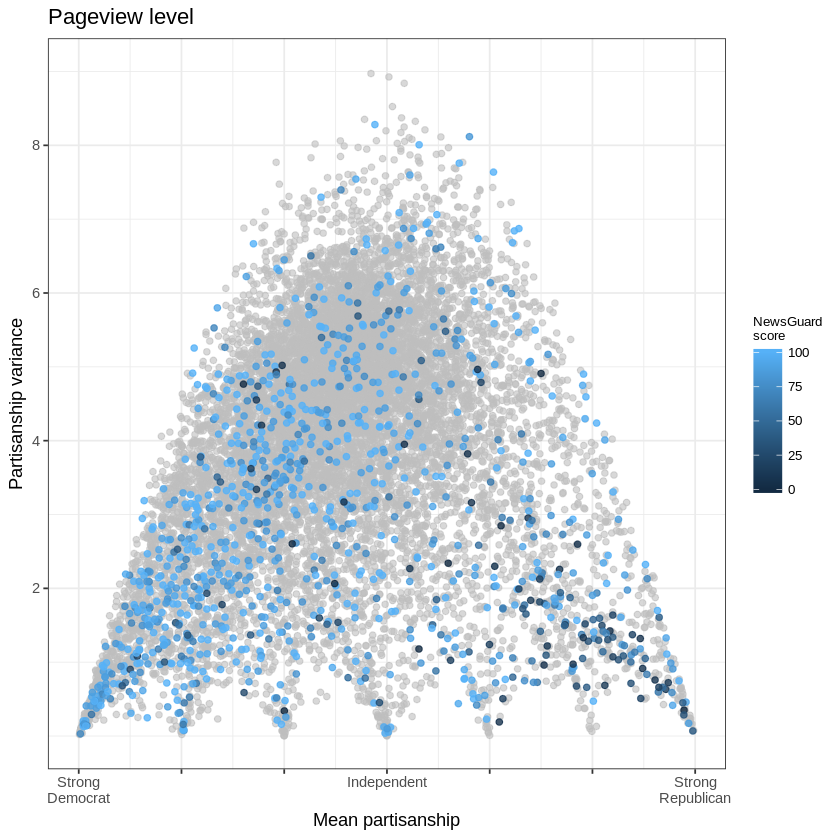

In [22]:
pulse %>% 
ggplot(aes(x = pageview_avg, y = pageview_var)) + 
geom_point(data = filter(pulse, is.na(Score)),
             aes(x = pageview_avg, y = pageview_var), 
             color = "grey", alpha = 0.6) +
geom_point(data = filter(pulse, !is.na(Score)),
             aes(x = pageview_avg, y = pageview_var, 
                 color = Score), alpha = 0.8) +
scale_color_gradient() +
theme_bw() +
theme(legend.title = element_text(size = 8),
        legend.text = element_text(size = 8)) +
scale_x_continuous(
    "Mean partisanship",
    limits = c(1, 7),
    breaks = seq(1,7, by = 1),
    labels = c("Strong\nDemocrat", "", "", "Independent",
               "", "", "Strong\nRepublican")
) + 
scale_y_continuous(
    "Partisanship variance",
    limits = c(0, 9),
    breaks = seq(2, 8, by = 2)
) +  
ggtitle("Pageview level") +
labs(color = "NewsGuard\nscore")

## Figure 3 (Left)

__caption__: _Relationship between audience partisan diversity and news reliability for websites whose average visitor is a Democrat or a Republican (variance computed at user level). News reliability scores from NewsGuard._

Warning message:
“Removed 10703 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10703 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_smooth).”

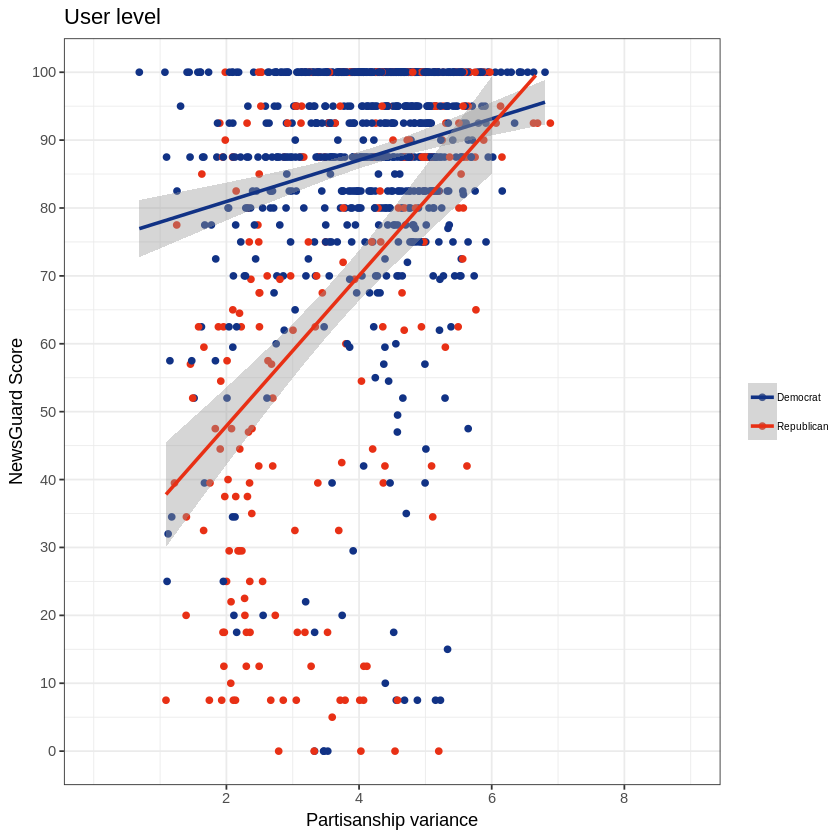

In [24]:
pulse %>%
filter(!is.na(is_conservative)) %>%
ggplot(aes(x = visitor_var, y = Score, 
             color = factor(is_conservative))) + 
geom_point() + 
geom_smooth(method = "lm") +
scale_x_continuous(
    "Partisanship variance",
    limits = c(0, 9),
    breaks = seq(2, 8, by = 2)
) +
scale_y_continuous(
    "NewsGuard Score",
    breaks = seq(0,100, by = 10),
    limits = c(0,100)
) + 
theme_bw() +
ggtitle("User level") +
scale_color_manual(
    values = c("#113285", "#E83015"),
    labels = c("Democrat", "Republican")
) +
theme(
    legend.title = element_blank(),
    legend.text = element_text(size = 6)
)

## Figure 3 (Right)

__caption__: _Relationship between audience partisan diversity and news reliability for websites whose average visitor is a Democrat or a Republican (variance computed at pageview level). News reliability scores from NewsGuard._

Warning message:
“Removed 10703 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10703 rows containing missing values (geom_point).”

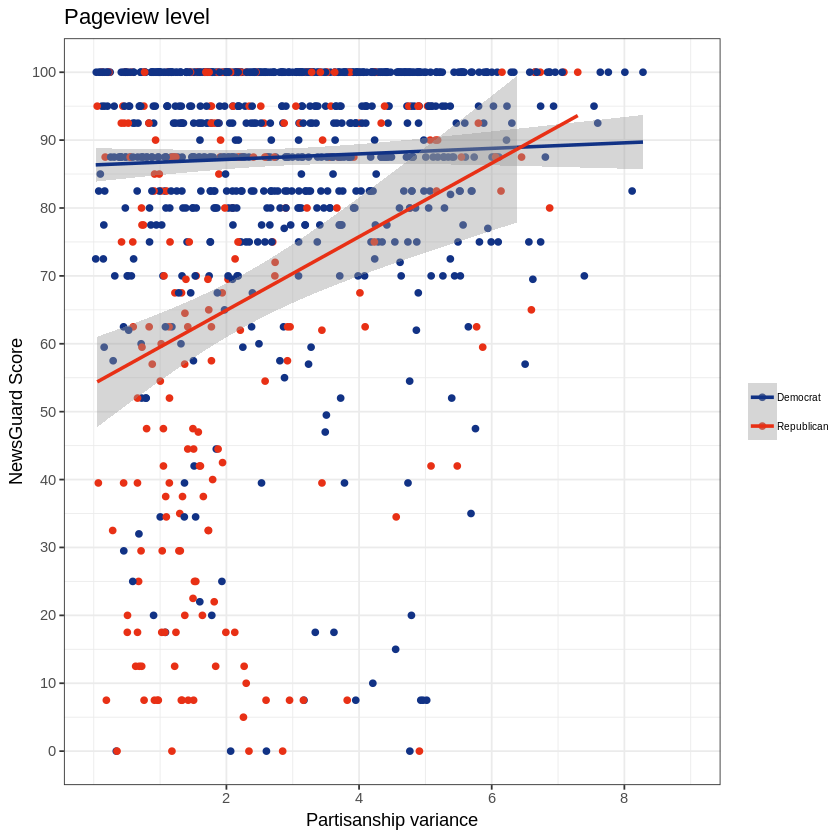

In [25]:
pulse %>% 
filter(!is.na(is_conservative)) %>%
ggplot(aes(x = pageview_var, y = Score, 
             color = factor(is_conservative))) + 
geom_point() + 
geom_smooth(method = "lm") +
theme_bw() +
scale_x_continuous(
    "Partisanship variance",
    limits = c(0, 9),
    breaks = seq(2, 8, by = 2)
) +
scale_y_continuous(
    "NewsGuard Score",
    breaks = seq(0,100, by = 10),
    limits = c(0,100)
) + 
ggtitle("Pageview level") +
scale_color_manual(
    values = c("#113285", "#E83015"),
    labels = c("Democrat", "Republican")
) +
theme(
    legend.title = element_blank(),
    legend.text = element_text(size = 6)
)

## Figure 7

__caption__: _Distribution of NewsGuard scores (N = 3,726) by trustworthiness rating. Domains that score below 60 points (i.e., untrustworthy) on the rubric used by NewsGuard are shown in white. Those that score 60 or above are shown in green. The bin width is 5; the bin containing score 60 also includes a few domains with lower scores. The dashed line indicates the average score in the data._

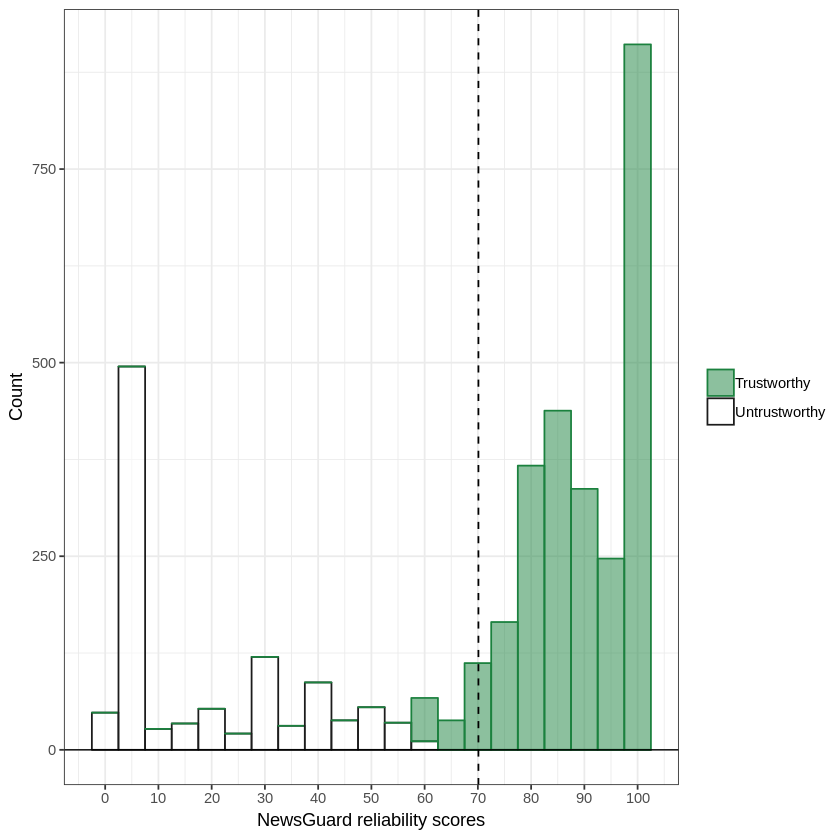

In [26]:
ng %>% 
filter(!is.na(Score)) %>%
mutate(is_good = ifelse(Score >= 60, "Trustworthy", "Untrustworthy") %>% 
           factor(levels = c("Trustworthy", "Untrustworthy"))) %>% 
ggplot(aes(x = Score, color = is_good, fill = is_good)) +
geom_histogram(binwidth = 5, alpha = 0.5) + 
theme_bw() +
xlab("NewsGuard reliability scores") + 
ylab("Count") +
scale_color_manual(
    values = c("#1b813e", "#1c1c1c"),
) +
scale_fill_manual(
    values = c("#1b813e", "white"),
) +
scale_x_continuous(breaks = seq(0,100, by = 10)) + 
geom_vline(xintercept = mean(ng$Score, na.rm = T), 
             linetype = "dashed", color = "black") +
geom_hline(yintercept = 0, color = "black", size = 0.4) + 
theme(legend.title = element_blank())